In [1]:
from pathlib import Path
import os
import pandas as pd
import re
import numpy as np

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [4]:
from transformers import BertTokenizerFast, BertModel, AdamW, get_linear_schedule_with_warmup

In [5]:
from project_path import project_path
project_path(1)

d:\Users\Nicholas\Projects\NLP\long_texts


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, precision_recall_fscore_support

In [7]:
# import from src
import src.models.models as models
import src.models.data_loader as data_loader
import src.models.training as training
import src.features.preprocess as preprocess

In [8]:
import pickle

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [11]:
# if gpu is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [12]:
# data directories
proj_dir = Path.cwd().parents[0]
data_raw = Path(proj_dir, 'data', 'raw')

In [13]:
PRE_TRAINED_MODEL_NAME = "D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1"
tokenizer = BertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
data = pd.read_csv(Path(data_raw, 'IMDB Dataset.csv'))

In [15]:
data['tokens'] = data['review'].progress_apply(tokenizer.tokenize)
data['n_tokens'] = data['tokens'].apply(len)

100%|██████████| 50000/50000 [00:44<00:00, 1130.61it/s]


In [16]:
# take data with long strings only
data = data.loc[data['n_tokens'] > 700, :]

In [17]:
data['target'] = (data['sentiment'] == 'positive').astype(int)

In [18]:
# Subsample
# data_sample, _ = train_test_split(data, train_size=0.1, random_state=RANDOM_SEED, shuffle=True, stratify=data['target'])
data_sample = data.copy()
data_sample = data_sample.rename(columns = {'review':'content'})
data_sample = data_sample.drop(['tokens', 'n_tokens'], axis=1)

#### Train test split

In [19]:
df_train, df_test = train_test_split(
    data_sample, 
    train_size=0.8, 
    random_state=RANDOM_SEED, 
    shuffle=True,
    stratify=data_sample['target'])

In [20]:
df_val, df_test = train_test_split(
    df_test, 
    train_size=0.5, 
    random_state=RANDOM_SEED, 
    shuffle=True, 
    stratify=df_test['target'])

In [21]:
print(df_train.shape, df_val.shape, df_test.shape)

(3219, 3) (402, 3) (403, 3)


In [22]:
print(df_train.target.value_counts(normalize = True))

0    0.541162
1    0.458838
Name: target, dtype: float64


#### Train model

In [23]:
PRE_TRAINED_MODEL_NAME = "D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1"
tokenizer = BertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [24]:
max_len = 512 * 4
batch_size = 32

In [25]:
train_data_loader = data_loader.create_data_loader(
    df = df_train, 
    tokenizer = tokenizer, 
    max_len = max_len, 
    batch_size = batch_size, 
    chunksize = 512, 
    sampler = None, 
    shuffle = True, 
    drop_last = True)

val_data_loader = data_loader.create_data_loader(
    df = df_val, 
    tokenizer = tokenizer, 
    max_len = max_len, 
    batch_size = batch_size, 
    chunksize = 512, 
    sampler = None, 
    shuffle = False, 
    drop_last = False)

test_data_loader = data_loader.create_data_loader(
    df = df_test, 
    tokenizer = tokenizer, 
    max_len = max_len, 
    batch_size = batch_size, 
    chunksize = 512, 
    sampler = None, 
    shuffle = False, 
    drop_last = False)

In [26]:
params_dict = {
    'PRE_TRAINED_MODEL_NAME':PRE_TRAINED_MODEL_NAME, 
    'n_classes':2, 
    'add_linear':[512,256], 
    'attn_bias':False, 
    'freeze_layer_count':8
}

In [27]:
model = models.HIBERT(**params_dict)

Some weights of the model checkpoint at D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'bert.pooler.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay

In [29]:
epochs = 4
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

total_steps = len(train_data_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [30]:
%%time
history = training.train_model(epochs, model, train_data_loader, val_data_loader, loss_fn, optimizer, device, scheduler)

Epoch 1 / 4
--------------------
Batch Train loss: 0.6965     Class 1 prop: 0.4375     ACC: 0.5625     F1: 0.6316     AUC: 0.4050     
Batch Train loss: 0.6916     Class 1 prop: 0.5938     ACC: 0.6562     F1: 0.7660     AUC: 0.7377     
Batch Train loss: 0.6902     Class 1 prop: 0.5938     ACC: 0.6875     F1: 0.7727     AUC: 0.6158     
Batch Train loss: 0.6931     Class 1 prop: 0.4688     ACC: 0.7812     F1: 0.8000     AUC: 0.6807     
Batch Train loss: 0.6983     Class 1 prop: 0.4062     ACC: 0.7188     F1: 0.6897     AUC: 0.7085     
Batch Train loss: 0.6759     Class 1 prop: 0.7188     ACC: 0.8125     F1: 0.8800     AUC: 0.9097     
Batch Train loss: 0.6976     Class 1 prop: 0.4375     ACC: 0.6875     F1: 0.6875     AUC: 0.7186     
Batch Train loss: 0.6987     Class 1 prop: 0.4375     ACC: 0.6875     F1: 0.6875     AUC: 0.6945     
Batch Train loss: 0.6956     Class 1 prop: 0.4688     ACC: 0.5938     F1: 0.6829     AUC: 0.5113     
Batch Train loss: 0.6937     Class 1 prop: 0.4375

In [31]:
pickle.dump(history, open('training_history.pkl', 'wb'))

#### plot history

In [32]:
history = pickle.load(open('training_history.pkl', 'rb'))

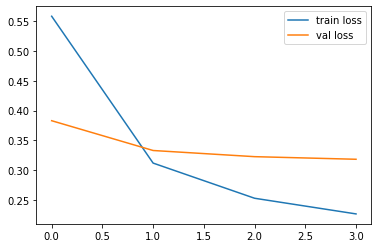

In [33]:
plt.plot(list(range(epochs)), history['train_loss'], label = 'train loss')
plt.plot(list(range(epochs)), history['val_loss'], label = 'val loss')
plt.legend()

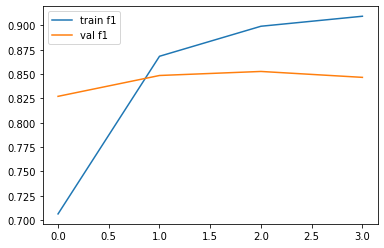

In [34]:
plt.plot(list(range(epochs)), history['train_f1'], label = 'train f1')
plt.plot(list(range(epochs)), history['val_f1'], label = 'val f1')
plt.legend()

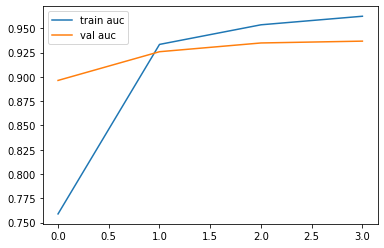

In [35]:
plt.plot(list(range(epochs)), history['train_auc'], label = 'train auc')
plt.plot(list(range(epochs)), history['val_auc'], label = 'val auc')
plt.legend()

#### make predictions

In [36]:
model_trained = models.HIBERT(**params_dict)
model_trained.load_state_dict(torch.load('best_model_state.bin'))

best_threshold = pickle.load(open('best_threshold.pkl', 'rb'))

Some weights of the model checkpoint at D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'bert.pooler.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
%%time

predictions = training.pred_model(
    model = model_trained, 
    data_loader = test_data_loader, 
    device = device, 
    best_threshold = best_threshold)

Wall time: 9min 10s


In [38]:
predictions_df = pd.DataFrame(predictions)

In [39]:
predictions_df

,target,pred_proba,pred,attn_wts,input_ids
0,1,0.966706,1,"[0.0014120473, 0.00056070235, 0.0001321961, 0....","[101, 1103, 5442, 18901, 1116, 1110, 1383, 110..."
1,1,0.953634,1,"[0.00036441008, 0.0003926487, 0.00037696285, 0...","[101, 1314, 1480, 117, 178, 2323, 170, 11954, ..."
2,0,0.238500,0,"[0.0011806161, 0.0014791595, 0.00078270934, 0....","[101, 1170, 3386, 4253, 1139, 3578, 2212, 2570..."
3,1,0.944499,1,"[0.00044823656, 0.00097208517, 0.0010118452, 0...","[101, 1105, 1128, 112, 173, 1129, 1268, 119, 1..."
4,0,0.029853,0,"[0.0016561487, 0.0015854748, 0.0022333933, 0.0...","[101, 1575, 117, 1930, 1103, 1436, 189, 119, 1..."
...,...,...,...,...,...
398,1,0.968305,1,"[0.0011577824, 0.0014268062, 0.00072956196, 0....","[101, 1191, 170, 2523, 1144, 1126, 8362, 8628,..."
399,0,0.056096,0,"[0.000654633, 0.0016489365, 0.0012175473, 0.00...","[101, 1103, 9178, 1116, 24887, 11079, 1106, 11..."
400,0,0.021809,0,"[0.0014445911, 0.0007230339, 0.0014416757, 0.0...","[101, 10614, 117, 1103, 6270, 1344, 4788, 6898..."
401,1,0.898898,1,"[0.0019639414, 0.00072984456, 0.00023015407, 0...","[101, 1103, 3980, 7693, 1110, 1383, 1107, 1103..."


#### Get tokens from ids

In [40]:
predictions_df['tokens'] = predictions_df['input_ids'].progress_apply(tokenizer.convert_ids_to_tokens)

100%|██████████| 403/403 [00:04<00:00, 87.70it/s]


#### join tokens and aggregate attention wts

In [41]:
%%time

new_tokens_attn = \
    predictions_df.progress_apply(lambda x: preprocess.combine_word_tokens(x['tokens'], x['attn_wts'], agg_fn='max'), axis=1)

100%|██████████| 403/403 [01:24<00:00,  4.76it/s]Wall time: 1min 24s



In [42]:
new_tokens_attn = new_tokens_attn.apply(pd.Series)

In [43]:
predictions_df['new_tokens'] = new_tokens_attn.iloc[:,0]
predictions_df['new_attn_wts'] = new_tokens_attn.iloc[:,1]

In [44]:
%%time

predictions_df['html'] = \
    predictions_df.progress_apply(lambda x: preprocess.create_html(x['new_tokens'], x['new_attn_wts']), axis=1)

100%|██████████| 403/403 [00:40<00:00, 10.06it/s]Wall time: 40.1 s



#### check results

In [45]:
nrows = 30

In [46]:
true_positives = \
    predictions_df[(predictions_df['target'] == 1) & (predictions_df['pred'] == 1)]\
        .sort_values('pred_proba', ascending = False).head(nrows)

In [47]:
with open('true_positives.html', 'w') as file:
    file.write('<br><br>'.join(true_positives.html))

In [48]:
false_positives = \
    predictions_df[(predictions_df['target'] == 0) & (predictions_df['pred'] == 1)]\
        .sort_values('pred_proba', ascending = False).head(nrows)

In [49]:
with open('false_positives.html', 'w') as file:
    file.write('<br><br>'.join(false_positives.html))

In [50]:
true_negatives = \
    predictions_df[(predictions_df['target'] == 0) & (predictions_df['pred'] == 0)]\
        .sort_values('pred_proba', ascending = True).head(nrows)

In [51]:
with open('true_negatives.html', 'w') as file:
    file.write('<br><br>'.join(true_negatives.html))

In [52]:
false_negatives = \
    predictions_df[(predictions_df['target'] == 1) & (predictions_df['pred'] == 0)]\
        .sort_values('pred_proba', ascending = True).head(nrows)

In [53]:
with open('false_negatives.html', 'w') as file:
    file.write('<br><br>'.join(false_negatives.html))